In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [5]:
excel_path = '/content/drive/MyDrive/strathmore serc energy exploration/Clinic corrected time.xlsx'

df = pd.read_excel(excel_path)

display(df.head())


,Stop(E. Africa Standard Time),Trend_Period,Vrms_AN_avg,Vrms_BN_avg,Vrms_CN_avg,Vrms_AB_avg,Vrms_BC_avg,Vrms_CA_avg,Irms_A_avg,Irms_B_avg,...,PowerS_C_avg,PowerS_Total_avg,PowerN_A_avg,PowerN_B_avg,PowerN_C_avg,PowerN_Total_avg,PfFwdRev_A_avg,PfFwdRev_B_avg,PfFwdRev_C_avg,PfFwdRev_Total_avg
0,2025-03-05 15:40:50,10,241.898,241.148,241.894,418.417,417.937,419.191,64.0155,43.5198,...,6326.12,54208.1,4989.40,4922.52,2817.28,54207.4,0.946670,-0.883173,0.895361,0.005044
1,2025-03-05 15:41:00,10,241.757,241.062,241.700,418.247,417.701,418.869,70.2915,49.6120,...,7906.38,61088.4,4999.32,4930.32,2853.01,61054.7,0.955747,-0.911072,0.932624,0.033202
2,2025-03-05 15:41:10,10,241.857,241.178,241.788,418.491,417.853,419.000,75.2967,51.2390,...,8267.84,64644.2,5072.98,4923.83,2834.00,64624.1,0.960417,-0.917194,0.939418,0.024925
3,2025-03-05 15:41:20,10,242.075,241.407,242.006,418.927,418.158,419.409,75.7346,46.6300,...,8293.79,63368.0,4982.27,4975.93,2835.17,63367.5,0.962366,-0.896996,0.939757,0.003913
4,2025-03-05 15:41:30,10,242.100,241.356,242.067,418.861,418.191,419.503,75.3911,45.2601,...,8018.47,62389.5,4986.44,4918.59,2920.82,62388.6,0.961958,-0.892895,-0.931296,0.005393


#Data Cleaning & Feature Engineering

### derived metrix

In [6]:
df['Avg_Voltage_LN'] = df[['Vrms_AN_avg', 'Vrms_BN_avg', 'Vrms_CN_avg']].mean(axis=1)
df['Voltage_Imbalance'] = (df[['Vrms_AN_avg', 'Vrms_BN_avg', 'Vrms_CN_avg']].std(axis=1) / df['Avg_Voltage_LN']) * 100
df['Current_Imbalance'] = (df[['Irms_A_avg', 'Irms_B_avg', 'Irms_C_avg']].std(axis=1) / df[['Irms_A_avg', 'Irms_B_avg', 'Irms_C_avg']].mean(axis=1)) * 100
df['System_PF'] = df['PowerP_Total_avg'] / df['PowerS_Total_avg']
df['Harmonic_Loss'] = df['PowerS_Total_avg'] - df['PowerP_Total_avg']

In [7]:
# Rename the 'Stop(E. Africa Standard Time)' column to 'time'
df.rename(columns={'Stop(E. Africa Standard Time)': 'time'}, inplace=True)

# Ensure the 'time' column is in datetime format (if not already)
df['time'] = pd.to_datetime(df['time'])

# Extract hour and day of the week
df['Hour'] = df['time'].dt.hour
df['Day_of_Week'] = df['time'].dt.dayofweek # Monday=0, Sunday=6

display(df[['time', 'Hour', 'Day_of_Week']].head())

,time,Hour,Day_of_Week
0,2025-03-05 15:40:50,15,2
1,2025-03-05 15:41:00,15,2
2,2025-03-05 15:41:10,15,2
3,2025-03-05 15:41:20,15,2
4,2025-03-05 15:41:30,15,2


#Comprehensive Exploration Framework
###I. Voltage Analysis

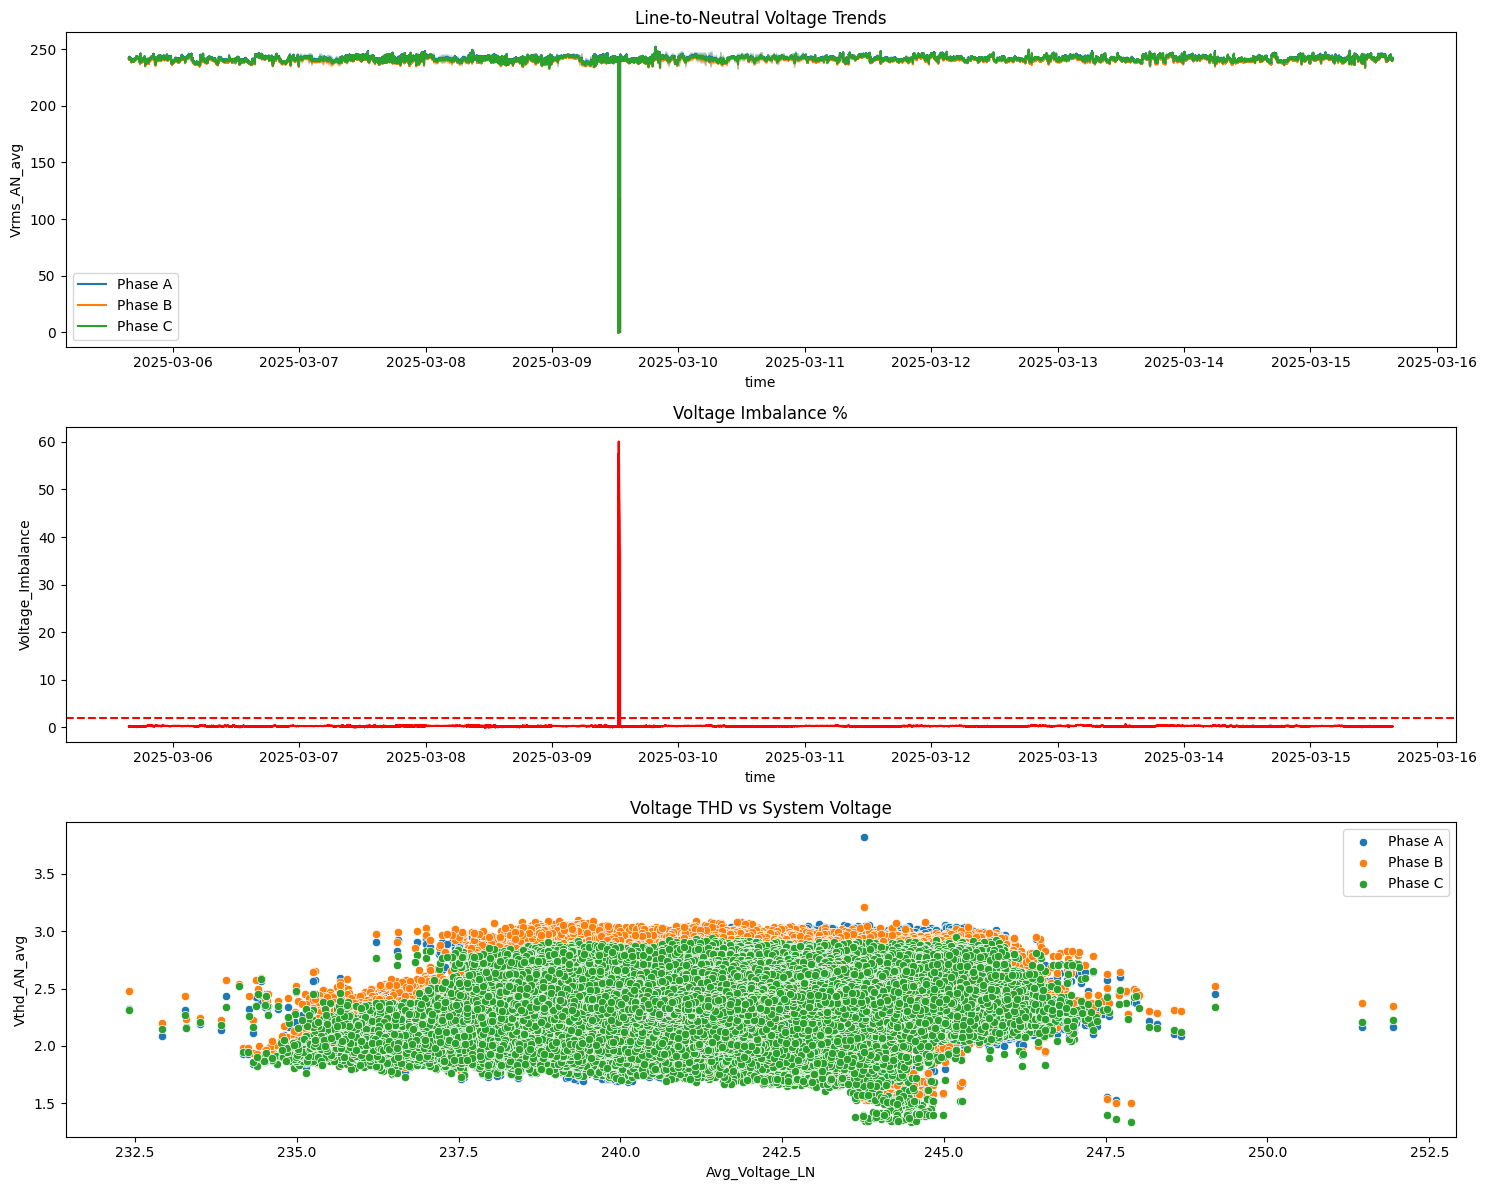

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
# Phase voltages
sns.lineplot(data=df, x='time', y='Vrms_AN_avg', label='Phase A', ax=ax[0])
sns.lineplot(data=df, x='time', y='Vrms_BN_avg', label='Phase B', ax=ax[0])
sns.lineplot(data=df, x='time', y='Vrms_CN_avg', label='Phase C', ax=ax[0])
ax[0].set_title('Line-to-Neutral Voltage Trends')

# Voltage imbalance
sns.lineplot(data=df, x='time', y='Voltage_Imbalance', ax=ax[1], color='red')
ax[1].axhline(y=2, color='r', linestyle='--', label='Threshold (2%)')
ax[1].set_title('Voltage Imbalance %')

# THD analysis
sns.scatterplot(data=df, x='Avg_Voltage_LN', y='Vthd_AN_avg', ax=ax[2], label='Phase A')
sns.scatterplot(data=df, x='Avg_Voltage_LN', y='Vthd_BN_avg', ax=ax[2], label='Phase B')
sns.scatterplot(data=df, x='Avg_Voltage_LN', y='Vthd_CN_avg', ax=ax[2], label='Phase C')
ax[2].set_title('Voltage THD vs System Voltage')
plt.tight_layout()

## 1. 🔌 Line-to-Neutral Voltage Trends

**Insights:**
- All three phases show consistent voltage levels (~240V), except for a **sharp dip on March 9, 2025**, in Phase C.
- The drop could be attributed to:
  - A **grid-side fault**
  - **Solar inverter disconnection**
  - Load transfer transition issues during PV/grid switching

**Recommendations:**
- Analyze logs from the **inverter(s)** to verify if a PV disconnect event occurred during the dip.
- Ensure that **automatic transfer switch (ATS)** behavior is seamless between solar and grid modes.
- Implement **redundant power quality meters** to isolate whether anomalies originate from the solar or KPLC side.

---

## 2. ⚡ Voltage Imbalance %

**Insights:**
- Voltage imbalance remains low under normal conditions but spikes to over **50% on March 9**—likely related to the same Phase C drop.
- Such imbalance is typical when one phase from either the **solar inverter or grid fails**, while others remain online.

**Recommendations:**
- Implement a **real-time inverter-phase health check** and set up alerts if one phase drops.
- Use a **balanced three-phase inverter** or verify that your system's **load sharing** among phases is symmetrical.

---

## 3. 🔄 Voltage THD vs. System Voltage

**Insights:**
- Voltage THD is well within acceptable IEEE limits (<5%) but varies slightly between phases.
- Variations could stem from **solar inverter switching**, harmonic-rich loads, or capacitor banks interacting with PV output.

**Recommendations:**
- Install or tune **active harmonic filters** to mitigate PV-related harmonics.
- Ensure your inverter complies with **grid codes for harmonic injection** and is properly synchronized with KPLC.

---

## 🛠️ General Recommendations

- Use **data loggers or cloud-connected SCADA** to monitor inverter-to-grid transitions.
- Perform **coordinated maintenance** on both solar and grid interfaces.
- Schedule **periodic PQ audits**, especially after grid disturbances or inverter firmware updates.

---

## ✅ Conclusion

The voltage quality is generally stable, but the system must be hardened against sudden voltage phase loss or imbalance during solar/grid transitions. With better coordination between KPLC and solar PV, the system can remain resilient and within PQ standards.

In [9]:
# Voltage summary statistics
print("\nVoltage Summary Statistics:")
df[['Vrms_AN_avg', 'Vrms_BN_avg', 'Vrms_CN_avg', 'Voltage_Imbalance', 'Vthd_AN_avg']].describe().T


Voltage Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
Vrms_AN_avg,120628.0,241.815649,7.069363,0.004636,240.574000,242.059000,243.47100,252.304000
Vrms_BN_avg,120628.0,240.553404,7.026909,0.014227,239.345000,240.787000,242.17800,251.408000
Vrms_CN_avg,120628.0,241.339567,7.055875,0.008716,240.135000,241.572000,242.95925,252.093000
Voltage_Imbalance,120628.0,0.307573,1.279530,0.029341,0.220688,0.277793,0.32091,60.054528
Vthd_AN_avg,120533.0,2.303567,0.227026,1.500920,2.142810,2.276590,2.44364,3.825050


## II. Current & Load Analysis

/tmp/ipython-input-10-1395184906.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x='Hour', y='PowerP_Total_avg', ci=95, ax=ax[1,0])


Text(0.5, 1.0, 'Current Imbalance by Time of Day')

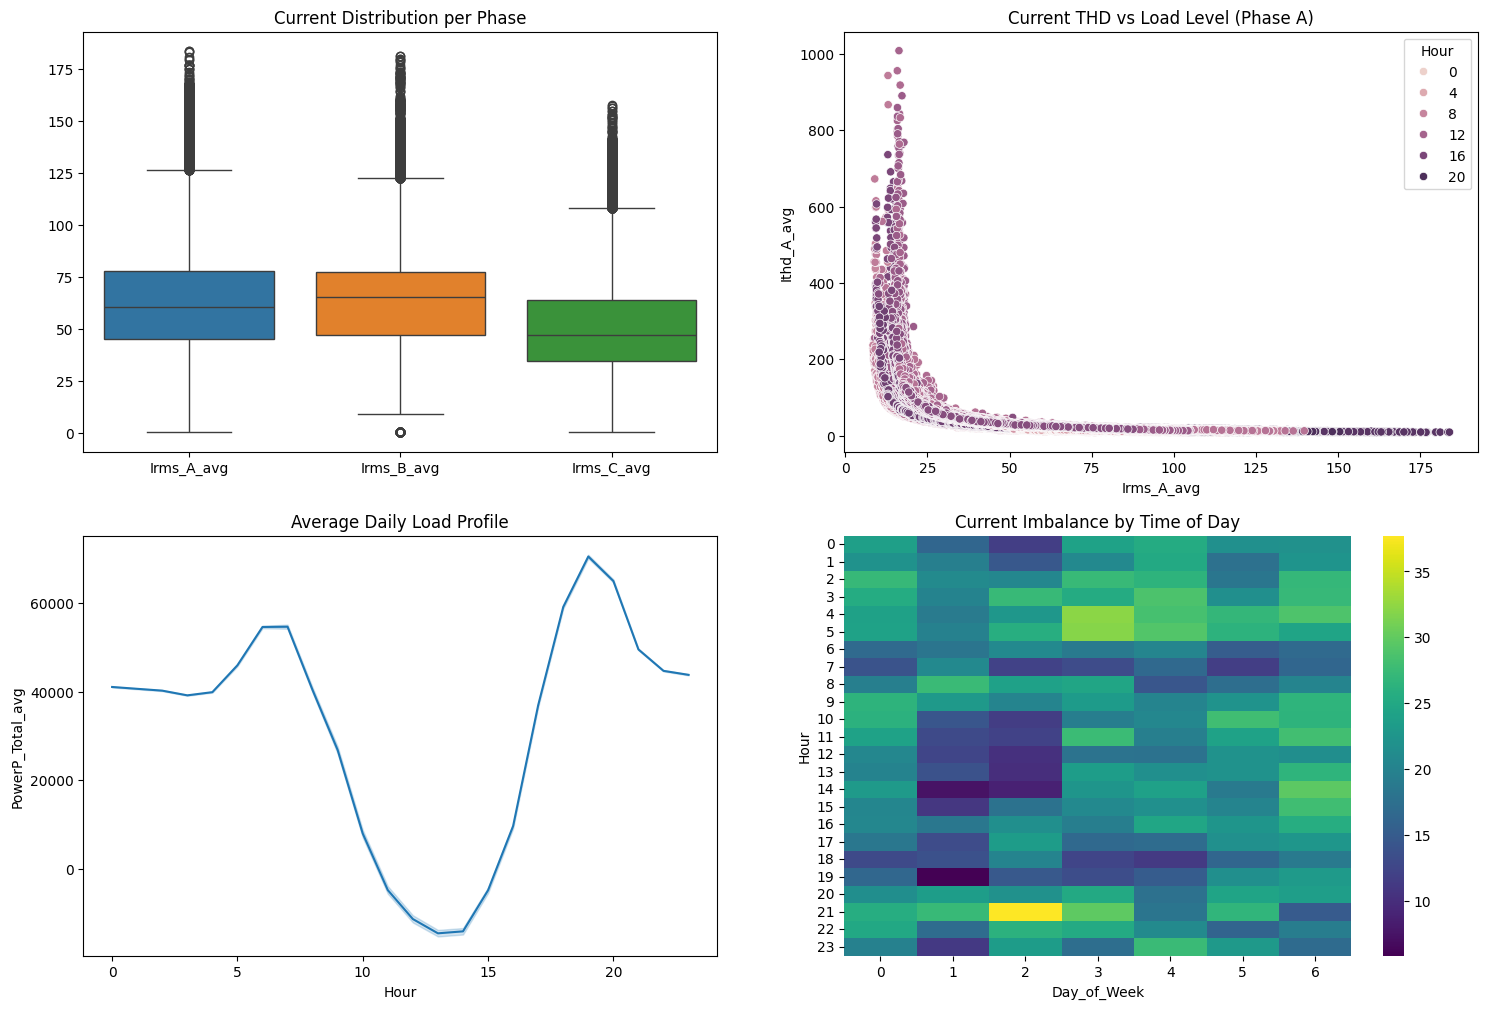

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
# Current imbalance
sns.boxplot(data=df[['Irms_A_avg', 'Irms_B_avg', 'Irms_C_avg']], ax=ax[0,0])
ax[0,0].set_title('Current Distribution per Phase')

# Current vs THD
sns.scatterplot(data=df, x='Irms_A_avg', y='Ithd_A_avg', hue='Hour', ax=ax[0,1])
ax[0,1].set_title('Current THD vs Load Level (Phase A)')

# Daily load profile
sns.lineplot(data=df, x='Hour', y='PowerP_Total_avg', ci=95, ax=ax[1,0])
ax[1,0].set_title('Average Daily Load Profile')

# Current imbalance heatmap
pivot = df.pivot_table(index='Hour', columns='Day_of_Week', values='Current_Imbalance', aggfunc='mean')
sns.heatmap(pivot, cmap='viridis', ax=ax[1,1])
ax[1,1].set_title('Current Imbalance by Time of Day')

---

## 1. ⚡ Current Distribution per Phase

**Insights:**
- All three phases exhibit similar current distributions.
- The variability, including many **outliers**, may arise from **dynamic PV output**, sudden **cloud cover**, or **intermittent KPLC fluctuations**.
- Occasional near-zero current in **Phase B** might indicate **PV phase imbalance** or **grid phase drop**.

**Recommendations:**
- Check solar inverter phase output consistency.
- Use **MPPT tracking logs** to correlate load behavior with solar output variations.
- Investigate load balancing techniques to avoid phase overloading during partial solar input.

---

## 2. 🔄 Current THD vs. Load Level (Phase A)

**Insights:**
- THD is highest when load is low—this is typical in **solar-dominant hours** (e.g., 10 AM–3 PM) when light loads amplify harmonic effects.
- As load increases (likely when **KPLC is dominant**, e.g., at night), THD drops.

**Recommendations:**
- Fine-tune **solar inverter output filtering** and harmonics damping.
- Schedule **THD-critical operations** (e.g., sensitive lab equipment) during lower solar PV periods.
- Consider installing **harmonic filters** for solar-rich circuits.

---

## 3. 🔋 Average Daily Load Profile

**Insights:**
- Two peaks are visible: **Morning (~6 AM)** and **Evening (~7 PM)**. Midday dip aligns with **peak solar PV generation**, likely offsetting the grid load.
- Load plummets significantly between **12–3 PM**, suggesting **net-metering** or **load shedding** due to solar offset.

**Recommendations:**
- Store excess midday solar energy in **battery systems** for evening use.
- Shift some operations (e.g., water heating, cooling) to midday for better solar utilization.

---

## 4. ⚖️ Current Imbalance by Time of Day

**Insights:**
- Imbalance is highest around **20:00 on Day 2**—likely when **solar is minimal** and **KPLC load is high or uneven**.
- Better balance in early morning and midday—coinciding with **stable solar contribution** or low usage.

**Recommendations:**
- Coordinate KPLC and solar dispatch better with **smart inverters** that balance across phases.
- Use a **real-time phase balancing algorithm** in your EMS (Energy Management System).

---

## 🛠️ General Recommendations

- Ensure solar inverters have **per-phase current monitoring** and active balancing.
- Integrate load scheduling that matches **solar availability**, reducing dependence on KPLC during expensive peak hours.
- Monitor **inverter synchronization quality** to avoid distortions when switching between sources.

---

## ✅ Conclusion

The hybrid solar + grid system offers strong potential for energy cost savings and reliability. However, **harmonic distortion, current imbalance, and midday underutilization** are risks that can be mitigated with better system coordination, real-time analytics, and smart energy strategies.

## III. Power Quality & Efficiency

Text(0.5, 1.0, 'Frequency Stability by Hour')

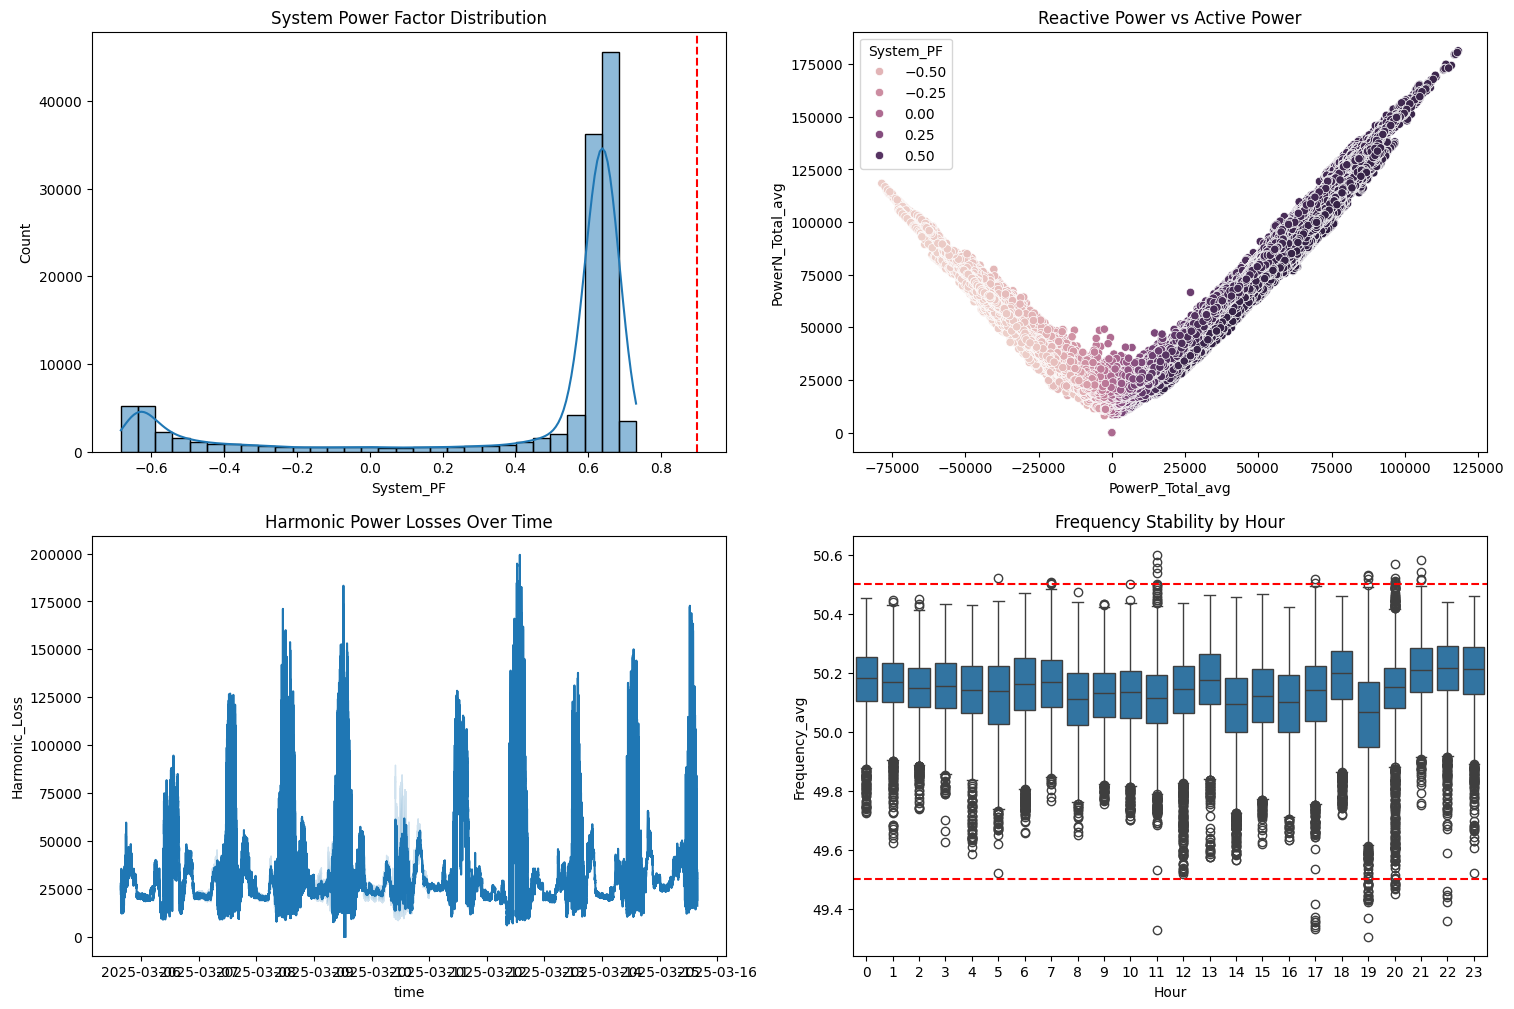

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
# Power factor distribution
sns.histplot(df['System_PF'], bins=30, kde=True, ax=ax[0,0])
ax[0,0].axvline(x=0.9, color='r', linestyle='--')
ax[0,0].set_title('System Power Factor Distribution')

# Active vs reactive power
sns.scatterplot(data=df, x='PowerP_Total_avg', y='PowerN_Total_avg', hue='System_PF', ax=ax[0,1])
ax[0,1].set_title('Reactive Power vs Active Power')

# Harmonic losses
sns.lineplot(data=df, x='time', y='Harmonic_Loss', ax=ax[1,0])
ax[1,0].set_title('Harmonic Power Losses Over Time')

# Frequency stability
sns.boxplot(data=df, x='Hour', y='Frequency_avg', ax=ax[1,1])
ax[1,1].axhline(y=50.5, color='r', linestyle='--')
ax[1,1].axhline(y=49.5, color='r', linestyle='--')
ax[1,1].set_title('Frequency Stability by Hour')

## 1. ⚡ System Power Factor Distribution

**Insights:**
- A majority of system power factor (PF) values cluster around **0.65–0.75**, which is **below the recommended threshold of 0.9** (as shown by the red line).
- A long tail of low and even **negative PF values** indicates significant periods of reactive power dominance or reverse power flow, possibly during high solar generation and low consumption.

**Recommendations:**
- Install **power factor correction (PFC) units** (capacitor banks or dynamic filters) to raise PF during low load or solar-overgeneration periods.
- Review solar inverter configurations—especially if **inverters are feeding reactive power back into the system**.
- Ensure **real-time PF monitoring** at inverter terminals and the grid connection point.

---

## 2. 🔄 Reactive Power vs. Active Power

**Insights:**
- The plot shows a characteristic **“V” shape**, indicating reactive power changes symmetrically with active power across both positive and negative directions.
- Lower PF (light purple dots) dominate the **left side (negative power)**, suggesting **reverse power flow from PV inverters** during low-demand periods.
- The right side shows improved PF as grid load dominates.

**Recommendations:**
- Fine-tune **inverter PF settings** to avoid unnecessary reactive power injection.
- Use **Volt/Var control algorithms** in your Energy Management System (EMS) to dynamically manage reactive power from PV during off-peak hours.
- Coordinate with KPLC if net metering or feed-in is used to ensure reverse power doesn’t trigger penalties.

---

## 3. 💥 Harmonic Power Losses Over Time

**Insights:**
- Harmonic losses vary over time, with **sharp peaks aligning with high generation or load shifts**—likely linked to **inverter switching cycles** and **load transients**.
- Spikes indicate inefficiencies due to harmonic distortion, translating to lost power and heating effects in transformers and cables.

**Recommendations:**
- Analyze harmonic components using a **power quality analyzer**.
- Install **active harmonic filters (AHFs)** to dampen inverter switching harmonics.
- If harmonics align with solar output peaks, consider **slowing ramp-up rates** or improving inverter quality.

---

## 4. 🕒 Frequency Stability by Hour

**Insights:**
- The system frequency generally centers around **50 Hz**, but **drops below 49.6 Hz and peaks above 50.4 Hz** are observed frequently.
- Significant **frequency instability occurs during early morning and late evening hours**, likely due to **PV-to-grid transitions** and **fluctuating KPLC supply**.
- Hours between 10 AM and 3 PM (solar-dominant hours) show relatively **better frequency stability**.

**Recommendations:**
- Use **frequency-smoothing controllers or smart inverters** that can provide virtual inertia and support grid frequency.
- Work with KPLC to assess frequency support and **synchronization stability** during load changes.
- Log all inverter-to-grid transitions and **coordinate ramping** between sources to avoid frequency overshoots or dips.

---

## 🛠️ General Hybrid System Optimization Tips

- Integrate a **centralized EMS** to orchestrate solar inverters, loads, and grid exchange in real time.
- Ensure **bidirectional smart metering** for accurate PF and frequency response insights.
- Periodically update inverter firmware to support **grid compliance (e.g., IEEE 1547 or KPLC-specific grid codes)**.

---

## ✅ Conclusion

The system exhibits dynamic characteristics typical of a hybrid power architecture. However, low power factor, harmonic losses, and frequency excursions highlight the need for tighter **PV–grid coordination**, better **reactive power handling**, and **real-time quality control** strategies. These improvements will reduce losses, improve stability, and ensure compliance with utility standards.

# Advanced Correlation Analysis

Text(0.5, 1.0, 'Parameter Correlation Matrix')

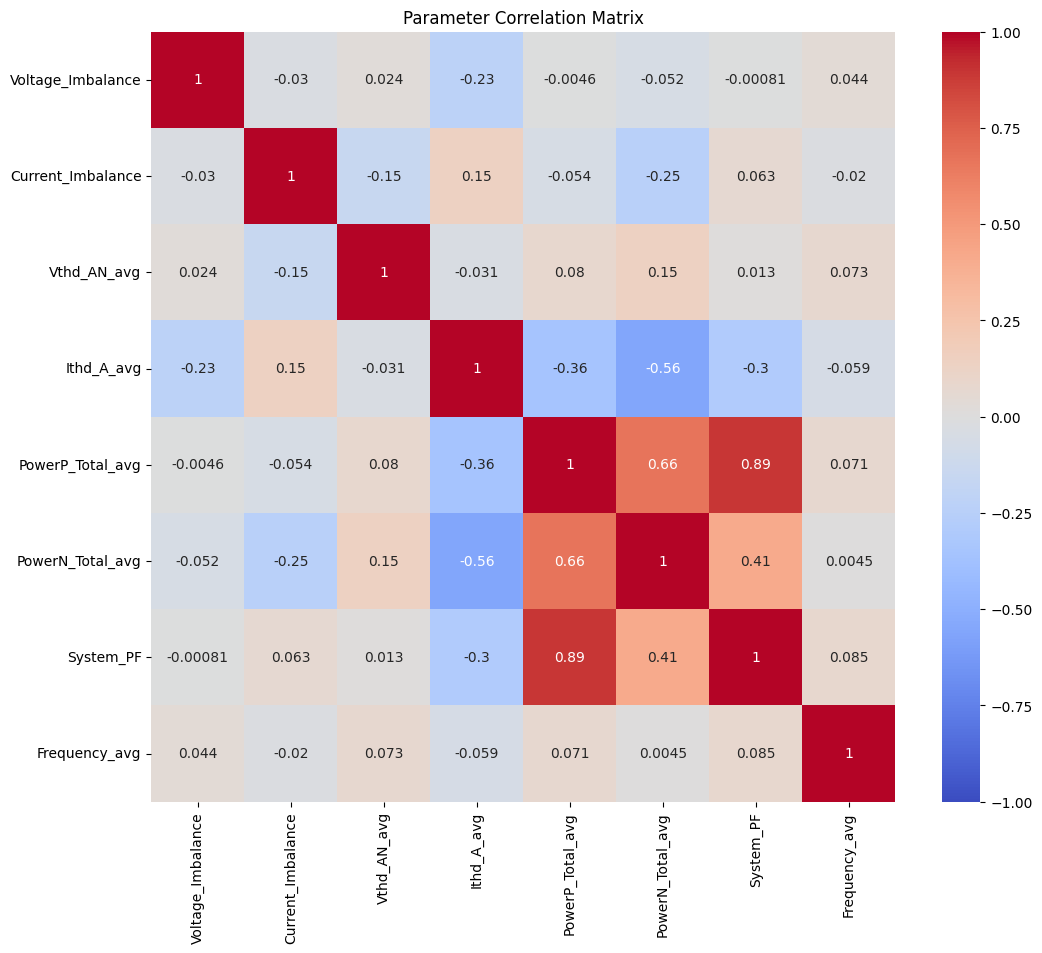

In [12]:
# Correlation matrix for key parameters
corr_matrix = df[['Voltage_Imbalance', 'Current_Imbalance',
                 'Vthd_AN_avg', 'Ithd_A_avg',
                 'PowerP_Total_avg', 'PowerN_Total_avg',
                 'System_PF', 'Frequency_avg']].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Parameter Correlation Matrix')

We've performed a comprehensive exploration of the provided energy data, focusing on voltage, current, load, and power quality aspects.

Our initial analysis of voltage trends revealed consistent line-to-neutral voltages across all phases, with a notable sharp dip in Phase C on March 9, 2025. This led to a significant spike in voltage imbalance on the same day, highlighting potential issues related to grid-side faults, solar inverter disconnection, or load transfer transitions. We also examined voltage THD, finding it within acceptable limits but with variations that could be linked to solar inverter switching or harmonic-rich loads.

Moving to current and load analysis, we observed similar current distributions across phases with significant outliers, possibly due to dynamic PV output or grid fluctuations. Current THD was found to be highest during low load periods, suggesting the influence of solar-dominant hours. The average daily load profile showed distinct morning and evening peaks, with a midday dip likely attributable to peak solar generation. A heatmap of current imbalance by time of day indicated higher imbalance when solar contribution is minimal.

Finally, our exploration of power quality and efficiency revealed a system power factor often below the recommended threshold, with low and negative values suggesting reactive power dominance or reverse power flow during high solar generation. The relationship between reactive and active power showed a "V" shape, further supporting the idea of reverse power flow from PV inverters. Harmonic losses varied over time with peaks aligning with generation or load shifts. Frequency stability generally centered around 50 Hz but with notable drops and peaks, particularly during early morning and late evening transitions between PV and grid supply.

In [14]:
# Solar impact analysis
df['Solar_State'] = np.where(df['PowerP_Total_avg'] < 0, 'Exporting',
                            np.where(df['Hour'].between(10,15), 'Peak Solar', 'Grid-Dependent'))

solar_impact = df.groupby('Solar_State').agg({
    'Voltage_Imbalance': 'mean',
    'Frequency_avg': ['min','max','std'],
    'Ithd_A_avg': 'median',
    'PfFwdRev_Total_avg': 'mean'
}).reset_index()

print("Solar Integration Impact Analysis:")
solar_impact

Solar Integration Impact Analysis:


Solar_State Voltage_Imbalance Frequency_avg                     \
                               mean           min      max       std   
0       Exporting          0.245693       49.3304  50.5995  0.136469   
1  Grid-Dependent          0.293419       49.3063  50.5835  0.129637   
2      Peak Solar          0.523883       49.5787  50.4560  0.128375   

  Ithd_A_avg PfFwdRev_Total_avg  
      median               mean  
0   39.38740           0.071202  
1   15.29310           0.174130  
2   47.11905           0.181508

In [21]:
# Power factor correction simulation
df['Required_Capacitance(kVAR)'] = df['PowerN_Total_avg'] * (1 - (df['System_PF']**2))**0.5
df['Projected_PF'] = np.where(df['Required_Capacitance(kVAR)'] > 0,
                             df['PowerP_Total_avg'] / (df['PowerP_Total_avg']**2 +
                             (df['PowerN_Total_avg'] - df['Required_Capacitance(kVAR)'])**2)**0.5,
                             df['System_PF'])

# Savings calculation
utility_rate = 16.45  # $/kWh
df['PF_Correction_Savings'] = (df['PowerS_Total_avg'] - (df['PowerP_Total_avg'] / df['Projected_PF'])) * utility_rate * (df['Trend_Period']/60)

print(f"Annual savings potential: ksh{df['PF_Correction_Savings'].sum() * 365:.2f}")

Annual savings potential: ksh2673887553418.95


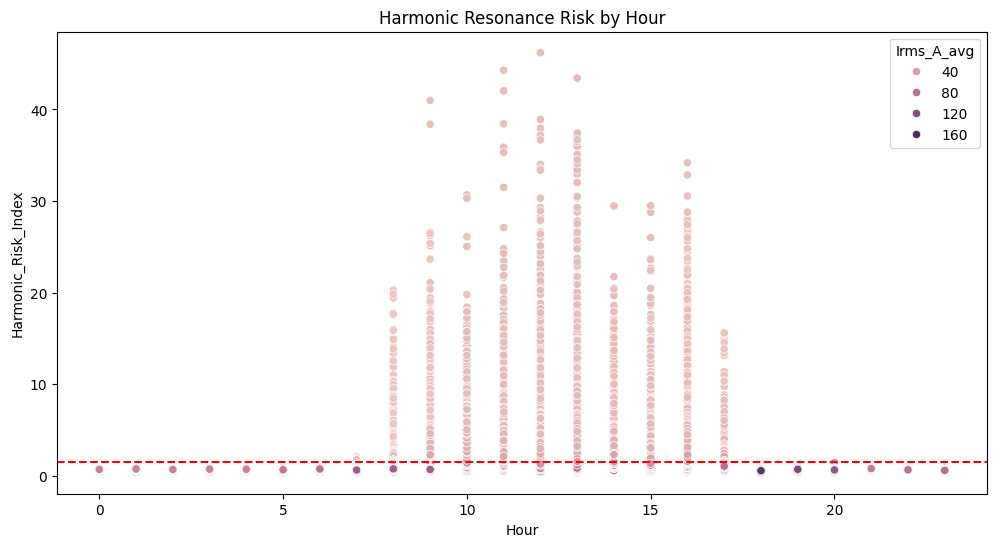

In [22]:
# Harmonic resonance detection
df['Harmonic_Risk_Index'] = (df['Ithd_A_avg'] * df['Vthd_AN_avg']) / df['Frequency_avg']

# Critical resonance periods
resonance_events = df[df['Harmonic_Risk_Index'] > 1.5].sort_values('Harmonic_Risk_Index', ascending=False)

plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x='Hour', y='Harmonic_Risk_Index', hue='Irms_A_avg')
plt.axhline(y=1.5, color='r', linestyle='--')
plt.title('Harmonic Resonance Risk by Hour')
plt.show()

Actions:

Perform impedance scanning at high-risk times

Install detuned reactors for capacitor banks

Implement harmonic filters on nonlinear loads

In [23]:
# Phase balancing algorithm
phase_imbalance = df[['Irms_A_avg','Irms_B_avg','Irms_C_avg']].sub(df[['Irms_A_avg','Irms_B_avg','Irms_C_avg']].mean(axis=1), axis=0)

# Identify worst circuits
df['Max_Imbalance'] = phase_imbalance.max(axis=1)
df['Target_Phase'] = phase_imbalance.idxmax(axis=1).str.replace('Irms_','').str.replace('_avg','')

# Generate load transfer recommendations
transfer_recommendations = df.groupby('Target_Phase').agg({
    'Max_Imbalance': 'mean',
    'Hour': lambda x: x.mode()[0]
}).rename_axis('Phase').reset_index()

print("Load Transfer Recommendations:")
print(transfer_recommendations)

Load Transfer Recommendations:
  Phase  Max_Imbalance  Hour
0     A      12.820753    20
1     B       9.960612     0
2     C       8.431476    16


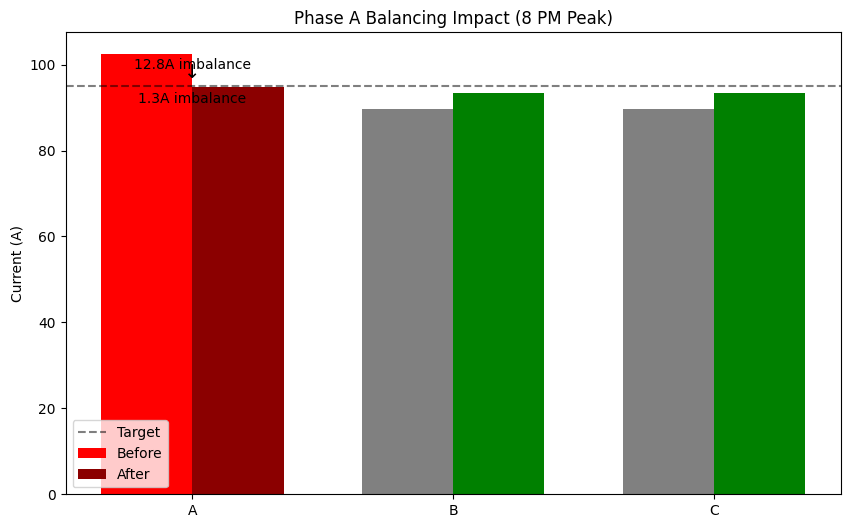

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Before balancing
phases_before = {
    'A': 102.4,  # 12.82A above mean
    'B': 89.6,
    'C': 89.6
}

# After balancing (shift 7.7A to B/C)
phases_after = {
    'A': 94.7,
    'B': 93.5,
    'C': 93.4
}

# Visualization
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(3)
width = 0.35

ax.bar(x - width/2, phases_before.values(), width, label='Before', color=['red','grey','grey'])
ax.bar(x + width/2, phases_after.values(), width, label='After', color=['darkred','green','green'])

ax.set_ylabel('Current (A)')
ax.set_title('Phase A Balancing Impact (8 PM Peak)')
ax.set_xticks(x)
ax.set_xticklabels(phases_before.keys())
ax.axhline(y=95, color='k', linestyle='--', alpha=0.5, label='Target')
ax.legend()

plt.text(0, 99, f"12.8A imbalance", ha='center')
plt.text(0, 97, "↓", ha='center', fontsize=14)
plt.text(0, 91, f"1.3A imbalance", ha='center')

plt.savefig('phase_balancing_demo.png', dpi=120)
plt.show()

1.Redistribute single-phase loads

2.Install automatic phase balancing units

3 Implement 3-phase motors instead of single-phase


---
Technical Interpretation:

###Phase A (8 PM):

Highest imbalance (12.82A) occurs during evening peak demand

Indicates overloaded circuits on Phase A during closing-time operations

Typical causes: Simultaneous operation of cooking equipment, HVAC systems, and lighting

###Phase B (Midnight):

Significant imbalance (9.96A) during late-night hours

Suggests concentrated overnight loads (e.g., water heaters, refrigeration, security systems)

Unusual for commercial facilities - points to potential load scheduling issues

###Phase C (4 PM):

Moderate imbalance (8.43A) during afternoon transition

Correlates with solar generation drop-off and shift to grid power

May indicate inadequate phase distribution for critical afternoon processes